# Classification of Sugarcane Diseases based on Images

## Environment Setup

First, ensure that all imports below are accessible. These are required to run the later parts of this Jupyter Notebook.

In [2]:
from pathlib import Path
from pprint import pprint

import keras  # pip install keras
from keras.api import applications
import keras_hub  # pip install keras-hub
import tensorflow as tf  # pip install tensorflow
import matplotlib.pyplot as plt  # pip install matplotlib
import numpy as np  # pip install numpy
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay  # pip install scikit-learn


2025-05-27 19:56:47.122146: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 19:56:47.131680: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 19:56:47.150634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748347007.169306   40730 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748347007.174632   40730 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748347007.200928   40730 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Data Loading and Preprocessing

Examining the train data shows that there are six (6) classes in total:


In [3]:
# The names of the classes found in the training data
classes = [
    "Banded_Chlorosis",
    "Brown_Rust",
    "Brown_Spot",
    "Viral",
    "Yellow_Leaf",
    "Healthy",
]

# To ensure consistency, the class names will be sorted alphabetically
classes.sort()

# Print classes to verify
print(classes)

['Banded_Chlorosis', 'Brown_Rust', 'Brown_Spot', 'Healthy', 'Viral', 'Yellow_Leaf']


Then, the next step is to examine the class distribution.

This is important because it would tell us whether class imbalance is present.

A `SEED` variable is declared to make random events deterministic.

The `TRAIN_DIRECTORY` contains the path to the train data

Note that the `label_mode` is set to `int` because in this problem, the classes are sparse categorical.

In [4]:
SEED = 1738  # To make random outcomes reproducible
TRAIN_DIRECTORY = Path("./train")  # The path of containing the train data, where each class is a folder


# Load the dataset
train_ds: tf.data.Dataset
validation_ds: tf.data.Dataset
ds = keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIRECTORY,
    labels="inferred",
    label_mode="int",  # sparse categorical
    class_names=classes,
    color_mode="rgb",
    batch_size=None,  # type: ignore ; to examine the distribution
)

# Get the class distribution by counting the number of occurences per class
def get_class_distribution(
    dataset, include_class_mappings: bool = False
) -> tuple[dict[int, int], dict[int, str]]:
    """ Get the class distribution and class name to class label mappings

    ## Args:
        **dataset**
        the image dataset

        **include_class_mappings**
        determines whether or not to create the class mappings dictionary
    """
    class_count = {}
    class_mappings = {}
    class_names = []
    if include_class_mappings:
        class_names = dataset.class_names

    # Go through each entry in the dataset
    for _, label in dataset:
        label_np = label.numpy()  # convert label into numpy form to be usable
        # Map the labels to the class name
        if len(class_names) > 0 and class_mappings.get(label_np) is None:
            class_mappings[label_np] = class_names[label_np]
        # Count the number of occurences per class
        if class_count.get(label_np) is None:
            class_count[label_np] = 1
            continue
        class_count[label_np] += 1
    return class_count, class_mappings

# Get the class distribution and class mappings using the function above
class_count, class_mappings = get_class_distribution(ds, True)

pprint(class_count)
pprint(class_mappings)

Found 4314 files belonging to 6 classes.


2025-05-27 19:56:59.446689: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


{np.int32(0): 424,
 np.int32(1): 282,
 np.int32(2): 1550,
 np.int32(3): 387,
 np.int32(4): 597,
 np.int32(5): 1074}
{np.int32(0): 'Banded_Chlorosis',
 np.int32(1): 'Brown_Rust',
 np.int32(2): 'Brown_Spot',
 np.int32(3): 'Healthy',
 np.int32(4): 'Viral',
 np.int32(5): 'Yellow_Leaf'}


2025-05-27 19:57:01.122317: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Since the classes are imbalanced, the class weights must be computed.

The calculated class weights will be used during model training to ensure that the imbalance does not affect the model.

Then to optimize training performance, a function which would cache and batch the dataset was created.

In [5]:
# Compute class weights
total_images = sum(class_count.values())
weights = {}
for key in class_count:
    weights[key] = total_images / (class_count[key] * len(classes))
pprint(weights)


# Batch the data set for model compatibility
# Cache to reduce latency
def config_performance(dataset: tf.data.Dataset, batch_size):
    dataset = dataset.cache()
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(tf.data.AUTOTUNE)

{np.int32(0): 1.695754716981132,
 np.int32(1): 2.549645390070922,
 np.int32(2): 0.4638709677419355,
 np.int32(3): 1.8578811369509043,
 np.int32(4): 1.204355108877722,
 np.int32(5): 0.6694599627560521}


With the class weights computed and stored in `weights`, it is time to train the models.

## Method 1: Convolution Neural Network (CNN)

The first method for solving the Sugarcane Image classification problem is through the use of a Convolutional Neural Network (CNN).


To ensure that the images are of the correct size, the function `image_dataset_from_directory` was called once more with the correct parameters.

A train-validation split of 80-20 was also implemented for validation purposes, to minimize overfitting.

Then, to `config_performance` was called to optize the datasets for performance.

During development, six different models were tested and the best one was used as the final model.

An `EarlyStopping` function was added to minimize overfitting by monitoring validation loss and its difference between each epoch.

For model compilation, 
- the optimizer used was `Adam`,
- the loss is `SparseCategoricalCrossentropy`
- the metric is only `SparseCategoricalAccuracy`

The recall, precision, and F1 score of the model will be calculated later on using `scikit-learn`.

The calculated class weights `weights` was added to the `fit` parameters to ensure that the class imbalance is addressed.

Feel free to configure the variables `EPOCHS`, `DROPOUT_RATE`, `BATCH_SIZE`, `IMAGE_SIZE` if ever you would like to train it yourself.

In [ ]:
EPOCHS = 30
DROPOUT_RATE = 0.2
BATCH_SIZE = 128
IMAGE_SIZE = 96

# Repeated here to prepare images with correct IMAGE_SIZE
train_ds: tf.data.Dataset
validation_ds: tf.data.Dataset
train_ds, validation_ds = keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIRECTORY,
    labels="inferred",
    label_mode="int",  # sparse categorical
    class_names=classes,  # ensure that the train data matches the expected classes
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),  # resize the image to the defined IMG_SIZE
    batch_size=None,  # type: ignore
    shuffle=True,  # shuffle the import
    seed=SEED,
    validation_split=0.2,
    subset="both",  # return both train and validation data sets
    pad_to_aspect_ratio=True,  # add black bars to ensure aspect ratio is split
    verbose=False,
)

# optimizing training and validation to not take up as much space on our GPU when training our models and minimize latency
# This is even more important when training six different models at once.
train_ds_optimized = config_performance(train_ds, BATCH_SIZE)
validation_ds_optimized = config_performance(validation_ds, BATCH_SIZE)

# A total of 6 models were chosen and tested
# InceptionResNetV2 performed the best of these and has been chosen as the final model for our model training
models = [
    # applications.InceptionV3,
    # applications.ResNet50V2,
    # applications.ResNet50,
    applications.InceptionResNetV2,
    # applications.MobileNetV3Large,
    # applications.MobileNetV3Small,
]

# Early stop was introduced to stop the training early if the validation loss increased too much
# Each val_loss must decrease by a minimum of 0.001 to continue running within 2 epochs, else stop and restore best weights
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.001, patience=2, mode="auto", restore_best_weights=True # type: ignore
)

# The following is the training of the model itself. Since only one model is used now,
# As such, only InceptionResNetV2 is being trained and 'model' refers to the ResNetV2 model.
for model in models:
    # We remove the top of the pre-trained model so that we can attach our own at the top later on.
    pre_trained_model = model(
        weights="imagenet",  # use imagenet weights
        classes=len(classes),
        include_top=False,  # The top layer will be replaced with the fully connected layer at the end
    )

    # To differentiate model outputs
    model_label = f"{pre_trained_model.name}-{EPOCHS}"
    print(model_label)

    #This is added to ensure that the pre-trained model's weights remain the same and are not retrained
    for layer in pre_trained_model.layers:
        layer.trainable = False

    # Define the model
    transfer_model = keras.models.Sequential(
        [
            # preprocessing layers
            keras.layers.Rescaling(1.0 / 255),  # ensure the values are within 0 to 1, instead of 0 to 255
            # data augmentation layers where none were used due to all affecting accuracy and loss too much
            # keras.layers.RandomFlip("horizontal_and_vertical", seed=SEED),
            # keras.layers.RandomBrightness(factor=0.2, seed=SEED),
            # keras.layers.RandomContrast(factor=0.1, seed=SEED),
            pre_trained_model,
            # fully connected
            # keras.layers.Flatten(),
            # Average pooling was used instead of flatten based on this paper which states that the performance improvements at the cost of some accuracy is acceptable
            # https://www.researchgate.net/publication/329466744_Reducing_Complexity_of_3D_Indoor_Object_Detection
            keras.layers.GlobalAveragePooling2D(),
            keras.layers.Dense(1024, activation="relu"),
            keras.layers.Dropout(DROPOUT_RATE),
            keras.layers.Dense(1024, activation="relu"),
            keras.layers.Dropout(DROPOUT_RATE),
            keras.layers.Dense(len(classes), activation="softmax"),
        ]
    )

    # Configure the optimizer, loss and metrics
    transfer_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),  # type: ignore
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="Accuracy"),
        ],
    )

    # Train the model
    history = transfer_model.fit(
        train_ds_optimized,
        epochs=EPOCHS,
        validation_data=validation_ds_optimized,
        class_weight=weights,
        callbacks=[early_stop],
    )

    # The final weights are then saved depending on the model's name.
    # In our case, the results of InceptionResNetV2 are saved.
    transfer_model.save(f"./results/models/{model_label}.keras")

Using 3452 files for training.
Using 862 files for validation.
inception_resnet_v2-30
Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - Accuracy: 0.3873 - loss: 1.8966 - val_Accuracy: 0.6845 - val_loss: 0.8703
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - Accuracy: 0.7439 - loss: 0.6744 - val_Accuracy: 0.7981 - val_loss: 0.5354
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - Accuracy: 0.8317 - loss: 0.4388 - val_Accuracy: 0.8492 - val_loss: 0.4061
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - Accuracy: 0.8788 - loss: 0.3171 - val_Accuracy: 0.8538 - val_loss: 0.4276
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - Accuracy: 0.9041 - loss: 0.2631 - val_Accuracy: 0.8643 - val_loss: 0.3808
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - Accuracy: 0.9131 - loss: 0.2261 - val_Accuracy: 0.9118 - val_loss: 0.2718
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - Accuracy: 0.9277 - loss: 0.1921 - val_Accuracy: 0.9002 - val_loss: 0.2876
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━

### Method 1: Model Results

Now that we have trained the model, it's time to test how well the model actually did.

There are a few ways we can do this. One of which is looking at the models precision, recall, and f1-scores, while another way is by looking at the resulting confusion matrix. We implement both of these methods to get a better idea of how well our model actually performed.

7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step 
                  precision    recall  f1-score   support

Banded_Chlorosis       0.79      0.79      0.79        82
      Brown_Rust       0.72      0.98      0.83        54
      Brown_Spot       1.00      0.94      0.97       314
         Healthy       0.96      0.95      0.95        75
           Viral       0.91      0.88      0.90       126
     Yellow_Leaf       0.95      0.96      0.96       211

        accuracy                           0.93       862
       macro avg       0.89      0.92      0.90       862
    weighted avg       0.93      0.93      0.93       862



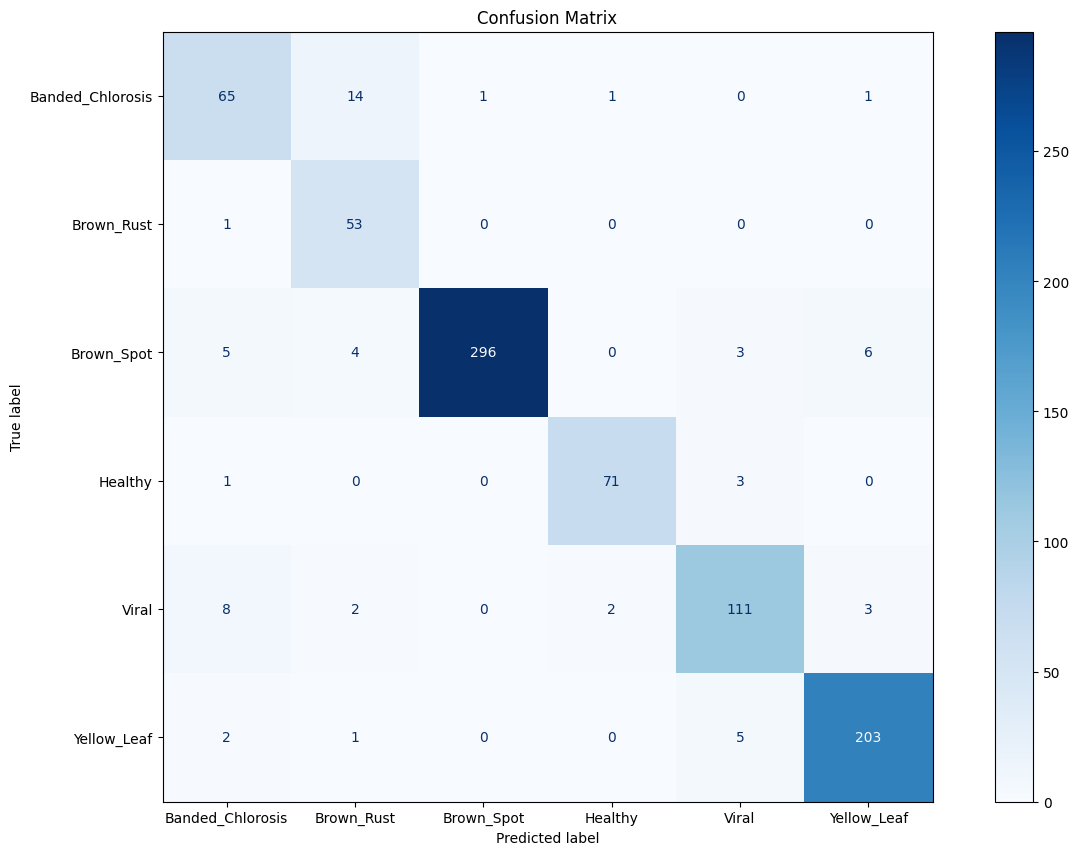

In [ ]:
# This is to get the predictions of the transfer model based on the data for validation
y_pred = transfer_model.predict(validation_ds_optimized)
y_pred_classes = np.argmax(y_pred, axis=1)  # get index of highest probability to convert probabilities to class indices

y_true = np.concatenate([y for _, y in validation_ds_optimized], axis=-1)  # type: ignore ; get labels

#This gives the report of the model and its precision, recall, and f1 score for each class
report = classification_report(y_true, y_pred_classes, target_names=classes)
print(report)

#This gives the confusion matrix of the model and shows how well (or not) the model predicted the validation images
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(16, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())  # type: ignore
plt.title("Confusion Matrix")
plt.show()

### Method 1: Model Plots

For an overview of how our CNN model performed over the course of its training, we can create plots to see the trend in the model's accuracy and losses. 


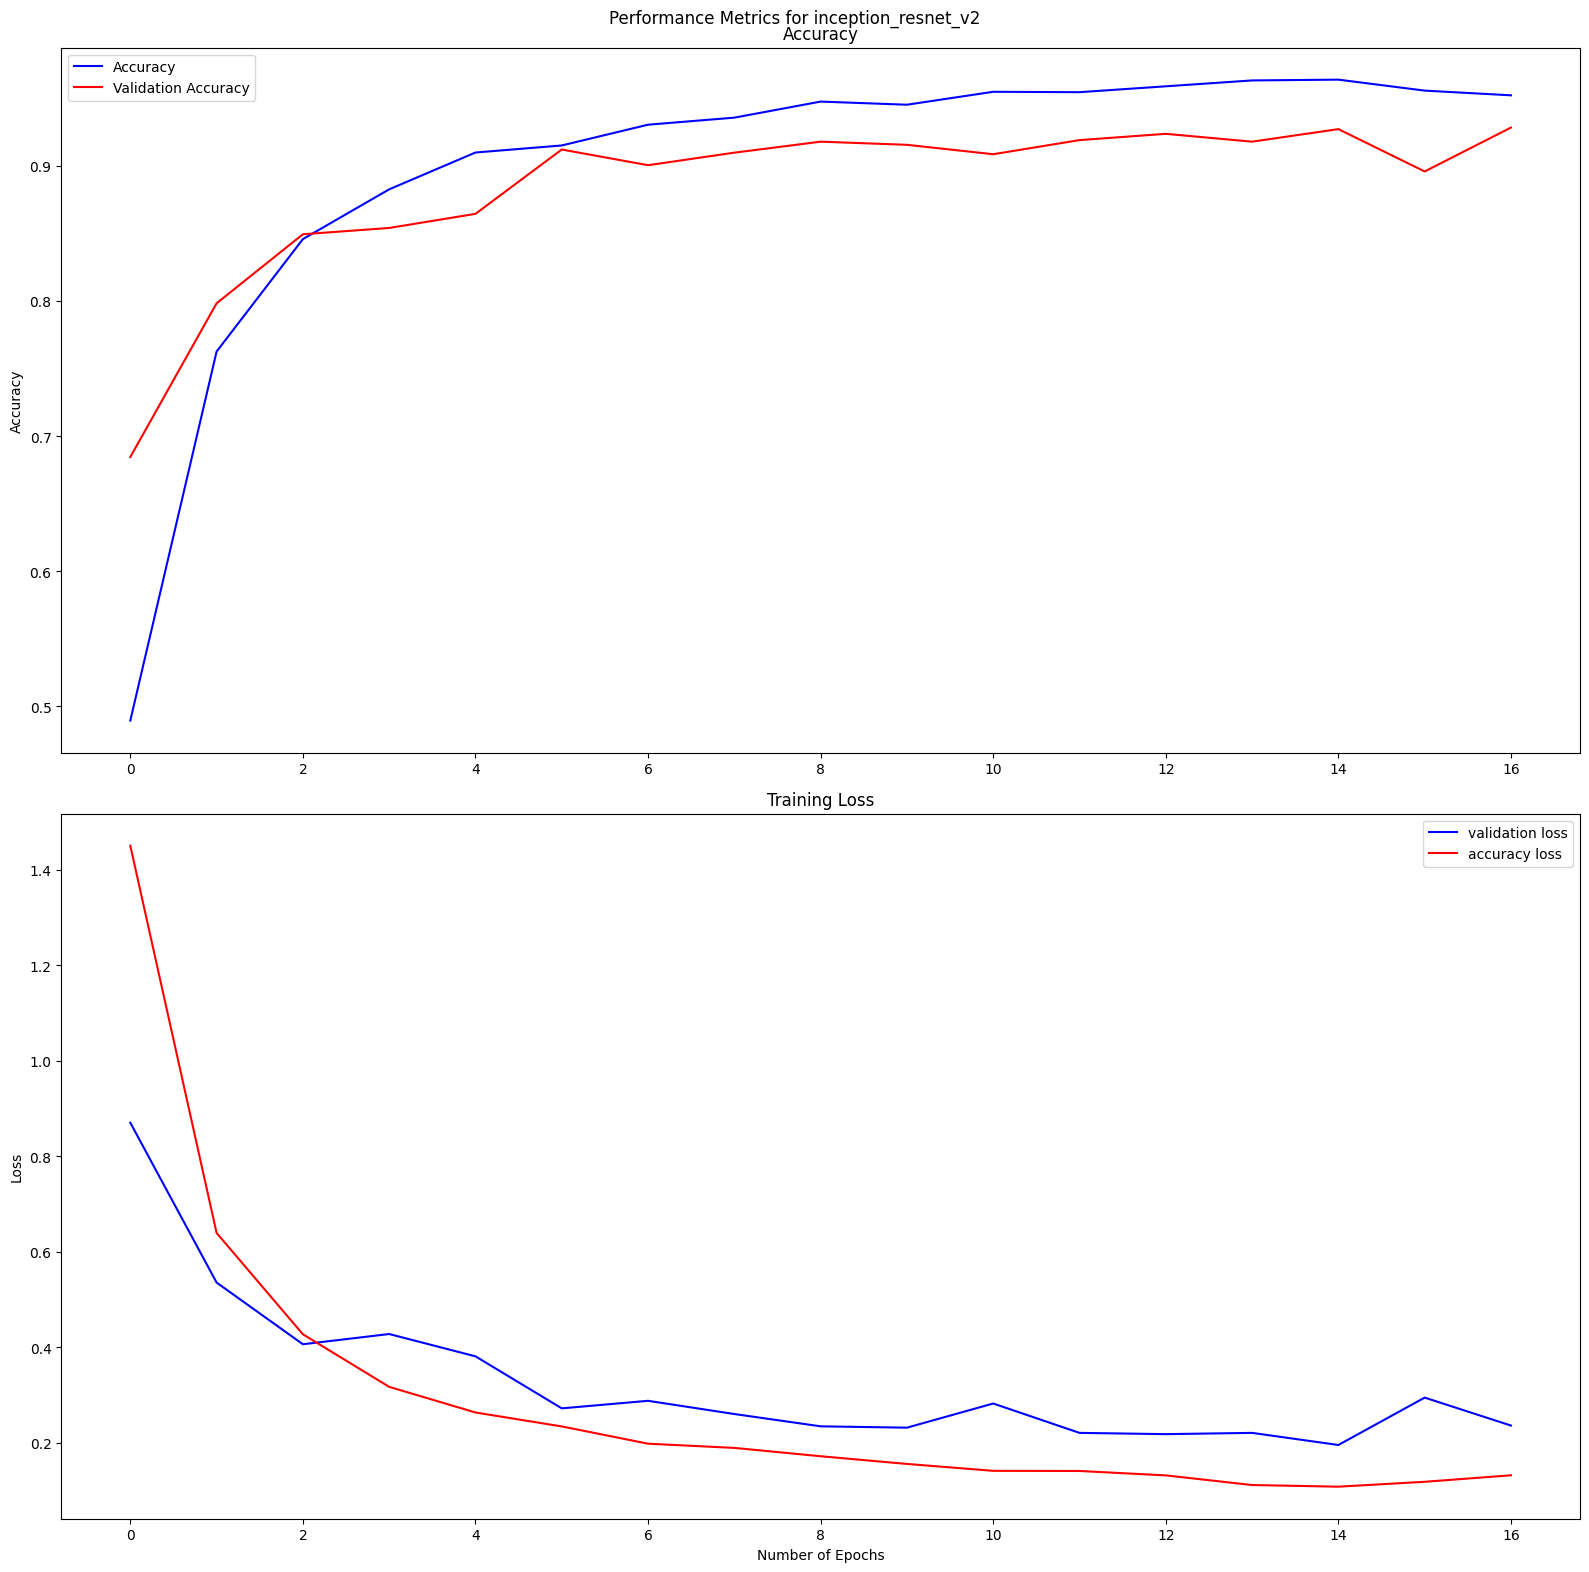

In [ ]:
def generate_metric_plots(history):
    fig, axs = plt.subplots(2)
    fig.set_size_inches(w=16, h=16)
    fig.set_layout_engine("tight")
    fig.suptitle(f"Performance Metrics for {pre_trained_model.name}")
    # Show the accuracy and validation accuracy
    axs[0].plot(history.history["Accuracy"], color="b", label="Accuracy")
    axs[0].plot(history.history["val_Accuracy"], color="r", label="Validation Accuracy")
    axs[0].set_title("Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    # show the training (and validation) loss
    axs[1].plot(history.history["val_loss"], color="b", label="validation loss")
    axs[1].plot(history.history["loss"], color="r", label="accuracy loss")
    axs[1].set_title("Training Loss")
    axs[1].set_xlabel("Number of Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].legend()
    plt.show()
    fig.savefig(f"./results/graph/{model_label}.png")


generate_metric_plots(history)

### Method 1: Model Summary

To see the parameters and its distribution across layers, we can use method `summary` on our model

In [ ]:
transfer_model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_11 (Rescaling)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 1, 1, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1024)           │     1,573,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,225,652 (237.37 MB)

 Trainable params: 2,629,638 (10.03 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

 Optimizer params: 5,259,278 (20.06 MB)

## Method 2: Vision Transformer

The second method for solving this classification problem is through the use of Vision Transformers.

Aside from Keras and Tensorflow, Keras Hub will be used to access more of pre-trained models and utilities.


Transfer learning was also used and in this case the base model is `vit_base_patch_16_224_imagenet21k`, because among the available ViT presets on Keras Hub, a [paper](https://informatica.si/index.php/informatica/article/view/7979#:~:text=The%20best%20tradeoff%20between%20accuracy,with%20lower%20accuracy%20than%20speed. ) cited that it was the ideal choice for us. 

A preprocessor layer was added at the start to ensure the images are of the correct format.

Different configurations of ViT models were tried but none were able to beat the accuracy of this setup. 

The same process is used in **Method 1** was used, with the only differences being: 
- `min_delta` for the `EarlyStopping` instance is not defined.
- the optimizer used is `NAdam` due to this [paper](https://pmc.ncbi.nlm.nih.gov/articles/PMC11232177/)


In [ ]:
EPOCHS = 15
BATCH_SIZE = 8
IMAGE_SIZE = 64
PRESET = "vit_base_patch16_224_imagenet21k"

# Repeated here to prepare images with correct IMAGE_SIZE
train_ds: tf.data.Dataset
validation_ds: tf.data.Dataset
train_ds, validation_ds = keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIRECTORY,
    labels="inferred",
    label_mode="int",
    class_names=classes,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=None,  # type: ignore
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="both",
    pad_to_aspect_ratio=True,
    verbose=False,
)

# optimizing training and validation to not take up as much space on our GPU when training our models
# This is even more important when training six different models at once.
train_ds_optimized = config_performance(train_ds, BATCH_SIZE)
validation_ds_optimized = config_performance(validation_ds, BATCH_SIZE)

# We will be using the ViT Image Classifier from the keras library as our pre trained model
pre_trained_model = keras_hub.models.ViTImageClassifier.from_preset(
    PRESET, num_classes=len(classes), load_weights=True, activation="softmax",
)

vit_model = keras.models.Sequential(
    [
        keras_hub.layers.ViTImageConverter.from_preset(  # converts images to the format expected by a ViT model
            PRESET,
            scale=1 / 255,  # ensure the values are within 0 to 1, instead of 0 to 255
        ),
        pre_trained_model,
    ]
)

# vit_model.summary()

vit_model.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),  # type: ignore
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="Accuracy"),
    ],
)  # type: ignore

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2, restore_best_weights=True, verbose=1,
    )

history = pre_trained_model.fit(
    train_ds_optimized,
    epochs=EPOCHS,
    validation_data=validation_ds_optimized,
    class_weight=weights,
    callbacks=[early_stop],
)

/home/blunuggets/programs/CS180-2425.2-Project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using 3452 files for training.
Using 862 files for validation.
Epoch 1/15


/home/blunuggets/programs/CS180-2425.2-Project/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1748269017.203619  112165 service.cc:152] XLA service 0x7fc82c002bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748269017.203971  112165 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-05-26 22:16:58.159414: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748269022.780058  112165 cuda_dnn.cc:529] Loaded cuDNN version 91000
2025-05-26 22:17:15.679335: I external/local_xla/xla/stream_executor/cuda/su

431/432 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - loss: 0.8987 - sparse_categorical_accuracy: 0.6944

2025-05-26 22:20:53.402590: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_1', 40 bytes spill stores, 40 bytes spill loads



432/432 ━━━━━━━━━━━━━━━━━━━━ 292s 565ms/step - loss: 0.8971 - sparse_categorical_accuracy: 0.6950 - val_loss: 0.2014 - val_sparse_categorical_accuracy: 0.9316
Epoch 2/15
432/432 ━━━━━━━━━━━━━━━━━━━━ 218s 505ms/step - loss: 0.2230 - sparse_categorical_accuracy: 0.9386 - val_loss: 0.1368 - val_sparse_categorical_accuracy: 0.9490
Epoch 3/15
432/432 ━━━━━━━━━━━━━━━━━━━━ 220s 508ms/step - loss: 0.1425 - sparse_categorical_accuracy: 0.9576 - val_loss: 0.1136 - val_sparse_categorical_accuracy: 0.9548
Epoch 4/15
432/432 ━━━━━━━━━━━━━━━━━━━━ 220s 508ms/step - loss: 0.1240 - sparse_categorical_accuracy: 0.9615 - val_loss: 0.1422 - val_sparse_categorical_accuracy: 0.9420
Epoch 5/15
432/432 ━━━━━━━━━━━━━━━━━━━━ 220s 510ms/step - loss: 0.1049 - sparse_categorical_accuracy: 0.9628 - val_loss: 0.1065 - val_sparse_categorical_accuracy: 0.9501
Epoch 6/15
432/432 ━━━━━━━━━━━━━━━━━━━━ 220s 510ms/step - loss: 0.0913 - sparse_categorical_accuracy: 0.9701 - val_loss: 0.1019 - val_sparse_categorical_accuracy

In [ ]:
# The final weights are then saved depending on the model's name.
# In our case, the results of ResNet V2 are saved.
pre_trained_model.save(f"./results/models/ViT_test2.keras")

### Method 2: Model Results

Now that we have trained the model, it's time to test how well the model actually did.

Similar to the first method, we will be looking at the model's precision, recall, and f1-scores through the classification report and the resulting confusion matrix. 

108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 193ms/step
                  precision    recall  f1-score   support

Banded_Chlorosis       0.86      0.85      0.86        82
      Brown_Rust       0.83      0.98      0.90        54
      Brown_Spot       0.99      0.99      0.99       314
         Healthy       1.00      0.95      0.97        75
           Viral       0.93      0.92      0.92       126
     Yellow_Leaf       0.99      0.98      0.98       211

        accuracy                           0.96       862
       macro avg       0.93      0.94      0.94       862
    weighted avg       0.96      0.96      0.96       862



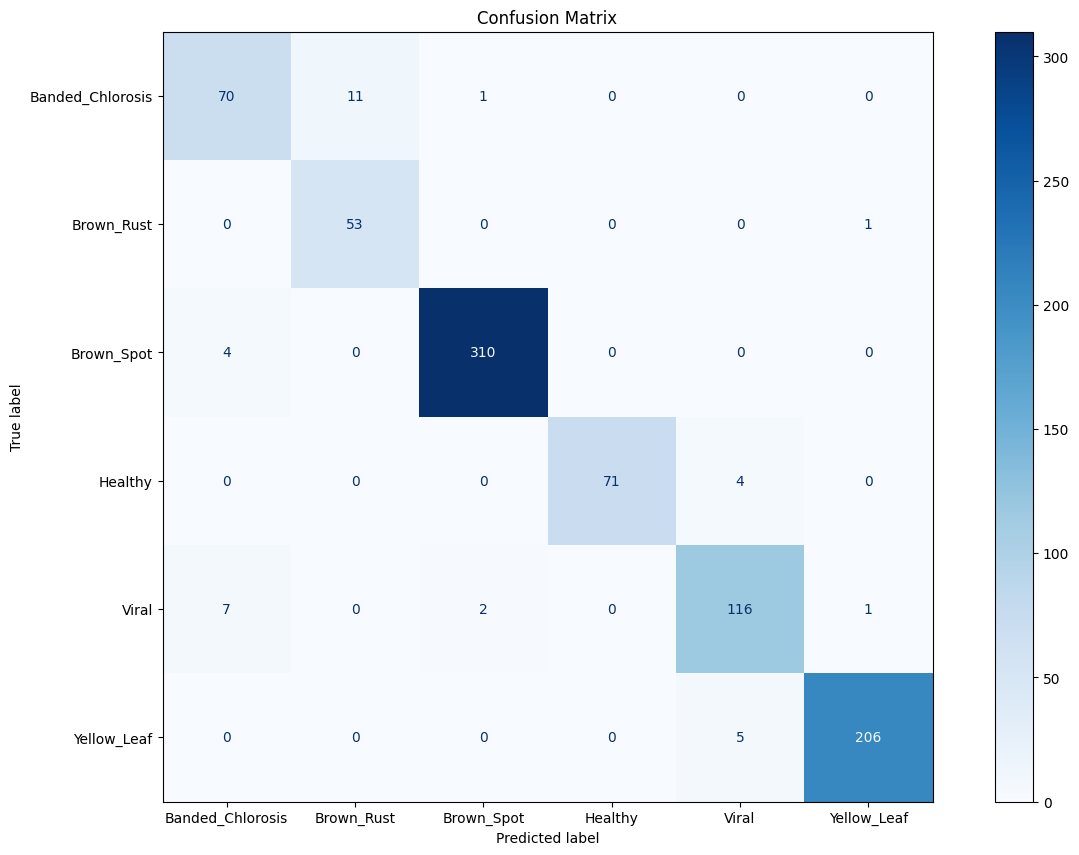

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# This is to get the predictions of the transfer model based on the data for validation
y_pred = pre_trained_model.predict(validation_ds_optimized)
y_pred_classes = np.argmax(y_pred, axis=1)  # get index of highest probability to convert probabilities to class indices

y_true = np.concatenate([y for _, y in validation_ds_optimized], axis=-1)  # type: ignore ; get labels

#This gives the report of the model and its precision, recall, and f1 score for each class
report = classification_report(y_true, y_pred_classes, target_names=classes)
print(report)

#This gives the confusion matrix of the model and shows how well (or not) the model predicted the validation images
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(16, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())  # type: ignore
plt.title("Confusion Matrix")
plt.show()

### Method 2: Model Plots

For an overview of how our ViT model performed over the course of its training, we can create plots to see the trend in the model's accuracy and losses. 


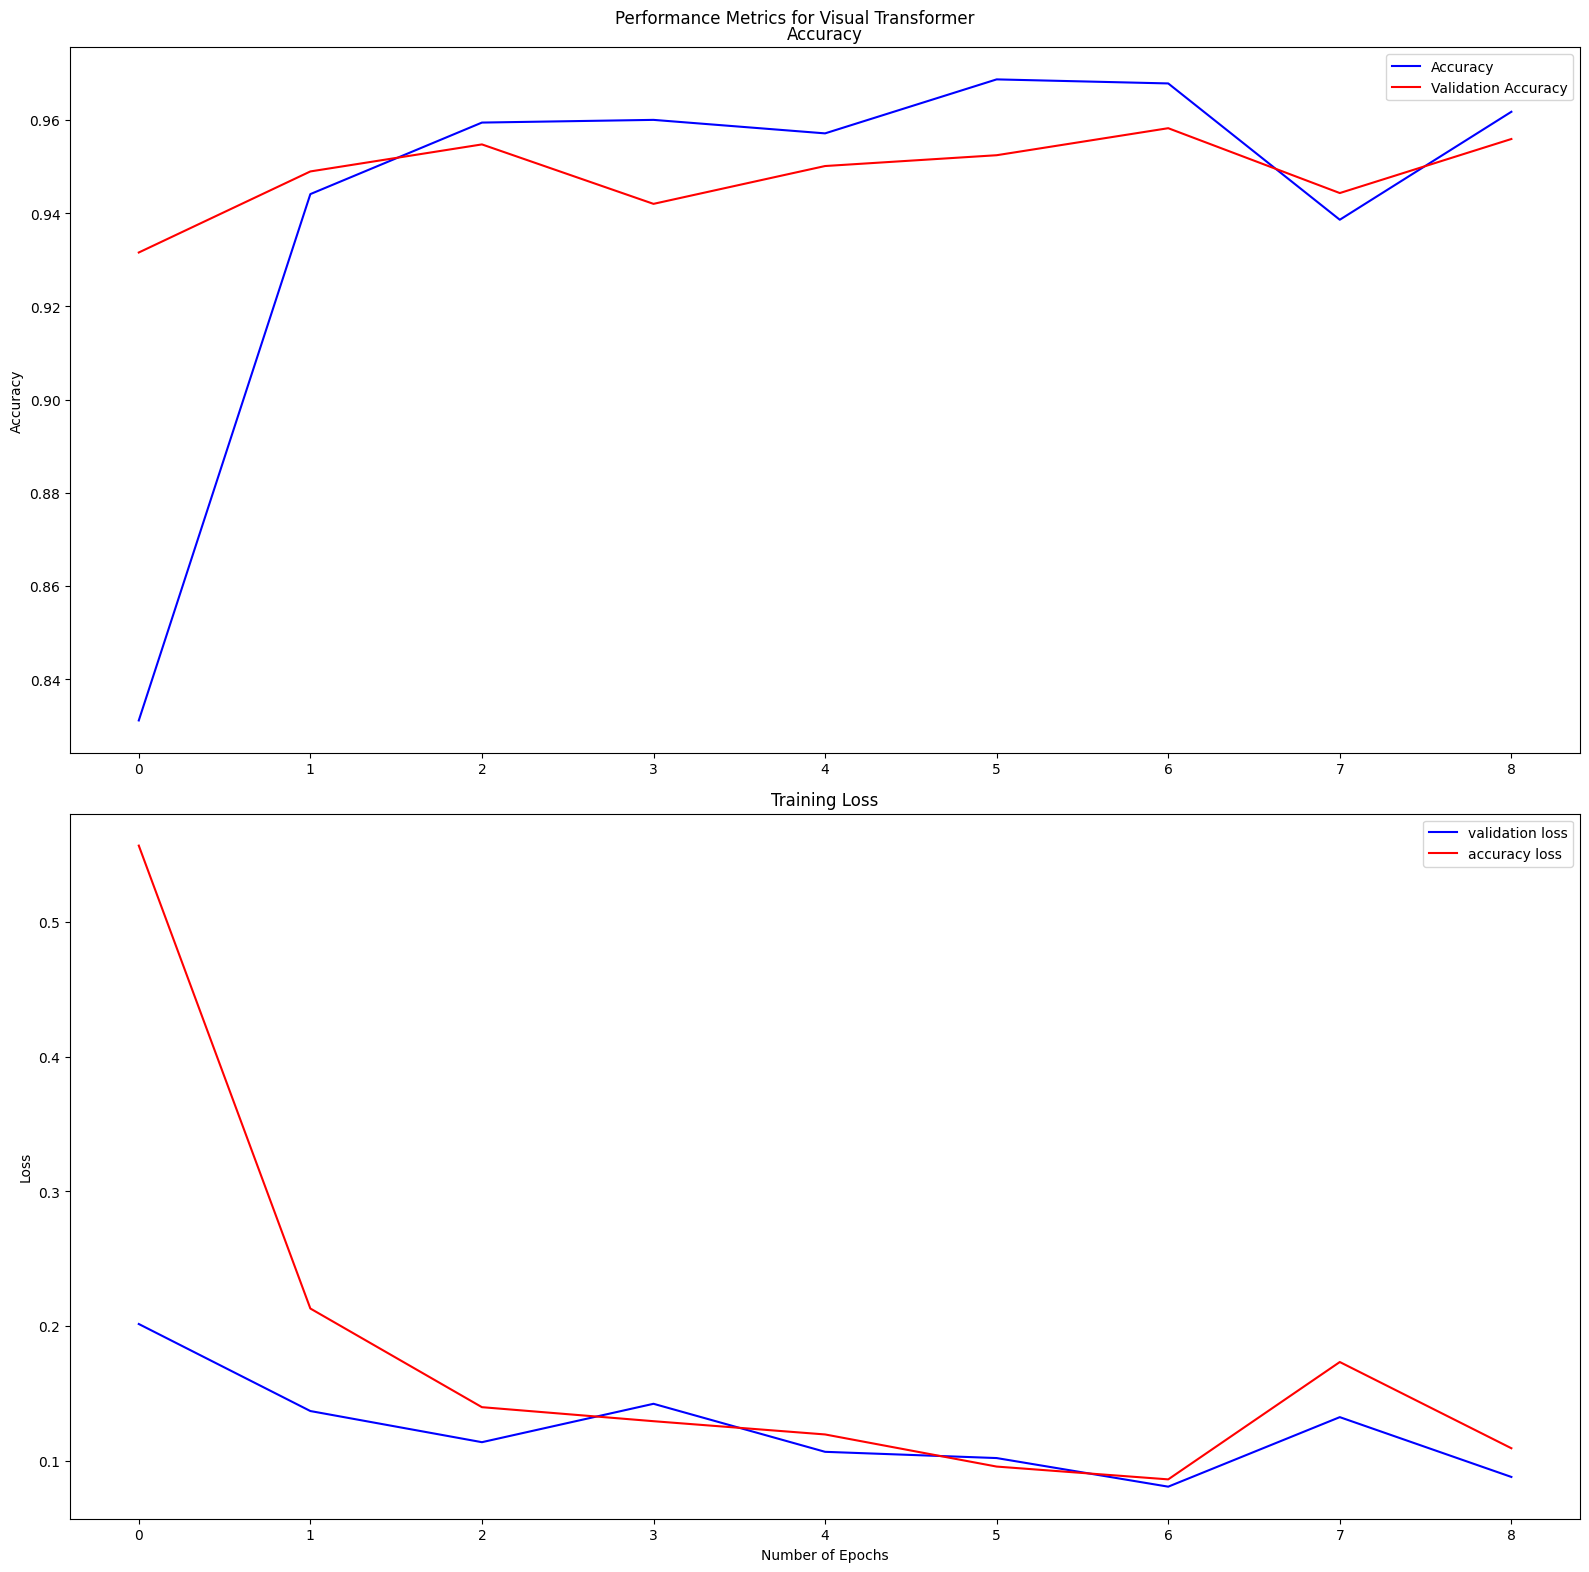

In [ ]:
def generate_metric_plots(history):
    fig, axs = plt.subplots(2)
    fig.set_size_inches(w=16, h=16)
    fig.set_layout_engine("tight")
    fig.suptitle(f"Performance Metrics for Visual Transformer")
    # Show the accuracy and validation accuracy
    axs[0].plot(history.history["sparse_categorical_accuracy"], color="b", label="Accuracy")
    axs[0].plot(history.history["val_sparse_categorical_accuracy"], color="r", label="Validation Accuracy")
    axs[0].set_title("Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    # show the training (and validation) loss
    axs[1].plot(history.history["val_loss"], color="b", label="validation loss")
    axs[1].plot(history.history["loss"], color="r", label="accuracy loss")
    axs[1].set_title("Training Loss")
    axs[1].set_xlabel("Number of Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].legend()
    plt.show()
    fig.savefig(f"./results/graph/ViT_test_2_graph.png")


generate_metric_plots(history)